# Clustering Restaurant Crimes and Venues

## Table Of Contents:

1. [Crime Clustering Using DBSCAN](http://localhost:8888/notebooks/Desktop/CAP/Clustering%20Restaurant%20Crimes%20and%20Restaurant%20Venues.ipynb#1.-Crime-Clustering-Using-DBSCAN)

2. [Venue Clustering Using DBSCAN](http://localhost:8888/notebooks/Desktop/CAP/Clustering%20Restaurant%20Crimes%20and%20Restaurant%20Venues.ipynb#1.-Crime-Clustering-Using-DBSCAN)

3. [Summary](http://localhost:8888/notebooks/Desktop/CAP/Clustering%20Restaurant%20Crimes%20and%20Restaurant%20Venues.ipynb#3.-Summary)


## *Import Libraries*

In [1]:
import pandas as pd #For data manipulation

import numpy as np #For data computation array,linear alegbra,etc.


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm #matplotlib color map
import matplotlib.colors as colors #to obtain colors for the color map


plt.style.use('ggplot') #for better looking graphs\

%matplotlib inline

import seaborn as sns #Another lib for better looking graphs 


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium #Map rendering library

# import machine learning  DBSCAN from clustering stage
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

## *Import Data Set*

In [2]:
crime_df = pd.read_csv('restaurant_crimes.csv')

venue_df = pd.read_csv('venue_data.csv')

In [3]:
print(crime_df.shape)
crime_df.head()

(685, 5)


,Borough,Crime Committed,Location of Crime,Latitude,Longitude
0,MANHATTAN,GRAND LARCENY,RESTAURANT/DINER,40.800106,-73.965960
1,MANHATTAN,BURGLARY,RESTAURANT/DINER,40.855242,-73.929407
2,MANHATTAN,BURGLARY,RESTAURANT/DINER,40.759307,-73.962201
3,MANHATTAN,GRAND LARCENY,RESTAURANT/DINER,40.716585,-73.988761
4,QUEENS,BURGLARY,RESTAURANT/DINER,40.755876,-73.912392


In [4]:
print(venue_df.shape)
venue_df.head()

(4168, 7)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,St. George,Staten Island,40.644982,-74.079353,M & K spanish restaurant,40.644112,-74.076950
1,St. George,Staten Island,40.644982,-74.079353,Green Tea Chinese Restaurant,40.644100,-74.076950
2,St. George,Staten Island,40.644982,-74.079353,May May Chinese Restaurant,40.644179,-74.076608
3,St. George,Staten Island,40.644982,-74.079353,Papouli's Restaurant,40.642357,-74.076728
4,St. George,Staten Island,40.644982,-74.079353,Beso,40.643306,-74.076508


## *Creating a Staten Island Crime Dataframe and a Venue Dataframe*

In [5]:
staten_crime = crime_df[crime_df['Borough'] == 'STATEN ISLAND']
print(staten_crime.shape)
staten_crime.head()

(16, 5)


,Borough,Crime Committed,Location of Crime,Latitude,Longitude
111,STATEN ISLAND,CRIMINAL MISCHIEF & RELATED OF,RESTAURANT/DINER,40.641738,-74.075678
296,STATEN ISLAND,OTHER OFFENSES RELATED TO THEF,RESTAURANT/DINER,40.624928,-74.143550
309,STATEN ISLAND,OTHER OFFENSES RELATED TO THEF,RESTAURANT/DINER,40.635692,-74.134994
408,STATEN ISLAND,GRAND LARCENY,RESTAURANT/DINER,40.511586,-74.249304
466,STATEN ISLAND,CRIMINAL MISCHIEF & RELATED OF,RESTAURANT/DINER,40.637492,-74.086915


In [6]:
staten_venue = venue_df[venue_df['Borough'] == 'Staten Island']
print(staten_venue.shape)
staten_venue.head()

(158, 7)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,St. George,Staten Island,40.644982,-74.079353,M & K spanish restaurant,40.644112,-74.076950
1,St. George,Staten Island,40.644982,-74.079353,Green Tea Chinese Restaurant,40.644100,-74.076950
2,St. George,Staten Island,40.644982,-74.079353,May May Chinese Restaurant,40.644179,-74.076608
3,St. George,Staten Island,40.644982,-74.079353,Papouli's Restaurant,40.642357,-74.076728
4,St. George,Staten Island,40.644982,-74.079353,Beso,40.643306,-74.076508


In [7]:
address = 'New York City, NY' 

geolocator = Nominatim(user_agent = 'ny_explorer') # Have to create user_agent to create an instance of geolocator
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

print('The coordinates of New York City is {} {}.'.format(latitude,longitude))

The coordinates of New York City is 40.7127281 -74.0060152.


## 1. Crime Clustering Using DBSCAN

**Clustering Staten Island restaurant crimes using latitude and longitude to get the "*hot spots*" location where the crime would be the most prevalent. Using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) because DBSCAN will be able to locate points of high density and put them in clusters while putting points in low density clusters as outliers. This helps separate crime "*hot spots*" from the "*cold spots*".**

Creating a crime df for clustering

In [8]:
crime =  staten_crime[['Crime Committed','Latitude','Longitude']]

crime.head()

,Crime Committed,Latitude,Longitude
111,CRIMINAL MISCHIEF & RELATED OF,40.641738,-74.075678
296,OTHER OFFENSES RELATED TO THEF,40.624928,-74.143550
309,OTHER OFFENSES RELATED TO THEF,40.635692,-74.134994
408,GRAND LARCENY,40.511586,-74.249304
466,CRIMINAL MISCHIEF & RELATED OF,40.637492,-74.086915


Standardize the data set to help create a standard distribution.

In [9]:
crime_scaler = StandardScaler().fit(crime[['Latitude','Longitude']])
crime_db = crime_scaler.transform(crime[['Latitude','Longitude']])

crime_db[0:5]

array([[ 1.01727714,  1.03572111],
       [ 0.67515189, -0.04007682],
       [ 0.89422666,  0.09553242],
       [-1.63153147, -1.71632451],
       [ 0.93086608,  0.85761304]])

Checking the optimal epsilon by finding the distance of the nearest neighbor for each point and then looking where elbow occurs and the change is most prevalent. Then sorting the distance of the points in a descending order and then selecting only the distances as the crime_dist variable. Lastly plotting the distances to see what is the optimal epsilon. 

Refrence Link:

The article used to find the optimal epsilon: [Finding the Optimal Epsilon in DBSCAN](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)

In [10]:
# Using 2 for n_neighbors because both points are included and we only looking the optimal distance between 2 points
crime_neigh = NearestNeighbors(n_neighbors=2)

# Fitting the data set with the nearest neighbors function
crime_cn = crime_neigh.fit(crime_db)

# Kneighbors creates two arrays one for the distances and the other for the index for each point
crime_dist, crime_ind = crime_cn.kneighbors(crime_db)

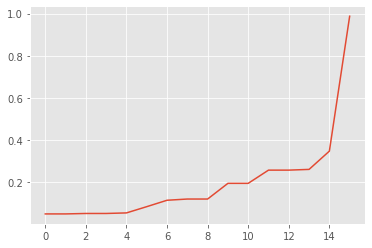

In [11]:
crime_dist = np.sort(crime_dist, axis=0)
crime_dist = crime_dist[:,1]
plt.plot(crime_dist)


Creating the model with the optimal epsilon and using the optimal way to find the min_sample by using the formula ln(n) where n is the size of the data set. Using this formula ln(16) = 2.77 I then round the answer to 3 to get the optimal min_sample.

Reference Link:

Section 4.1 in the following paper: [ST-DBSCAN: An algorithm for clustering spatial–temporal data](https://www.sciencedirect.com/science/article/pii/S0169023X06000218)

In [12]:
crime_model = DBSCAN(eps = 0.3, min_samples = 3)
crime_model.fit(crime_db)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

Creating a new column for the clusters.

In [13]:
crime = crime.copy()
crime['Clus Num'] = crime_model.labels_
crime.head()

,Crime Committed,Latitude,Longitude,Clus Num
111,CRIMINAL MISCHIEF & RELATED OF,40.641738,-74.075678,0
296,OTHER OFFENSES RELATED TO THEF,40.624928,-74.143550,-1
309,OTHER OFFENSES RELATED TO THEF,40.635692,-74.134994,-1
408,GRAND LARCENY,40.511586,-74.249304,1
466,CRIMINAL MISCHIEF & RELATED OF,40.637492,-74.086915,0


In [14]:
crime['Clus Num'].unique()

array([ 0, -1,  1])

Creating a outlier dataframe and a cluster dataframe for plotting purposes

In [15]:
crime_outlier = crime[crime['Clus Num'] == -1]
crime_outlier.head()

,Crime Committed,Latitude,Longitude,Clus Num
296,OTHER OFFENSES RELATED TO THEF,40.624928,-74.143550,-1
309,OTHER OFFENSES RELATED TO THEF,40.635692,-74.134994,-1
471,OTHER OFFENSES RELATED TO THEF,40.581537,-74.111744,-1
537,CRIMINAL MISCHIEF & RELATED OF,40.560792,-74.168360,-1
573,BURGLARY,40.572442,-74.107877,-1


In [16]:
crime_clus = crime[crime['Clus Num'] != -1]
crime_clus.head()

,Crime Committed,Latitude,Longitude,Clus Num
111,CRIMINAL MISCHIEF & RELATED OF,40.641738,-74.075678,0
408,GRAND LARCENY,40.511586,-74.249304,1
466,CRIMINAL MISCHIEF & RELATED OF,40.637492,-74.086915,0
469,BURGLARY,40.640057,-74.078375,0
481,BURGLARY,40.637824,-74.079687,0


In [17]:
# Creates the map of NYC using the latitude and longitude obtained from previous cell
ny_map = folium.Map(location=[latitude,longitude],zoom_start=10)




# Add the markers to the map

# Cluster
for lat,lng,num,crime in zip(crime_clus['Latitude'],crime_clus['Longitude'],crime_clus['Clus Num'],crime_clus['Crime Committed']):
    label = '{}'.format(crime)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=10,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
    
    
    
# Outlier  
for lat,lng,num,crime in zip(crime_outlier['Latitude'],crime_outlier['Longitude'],crime_outlier['Clus Num'],crime_clus['Crime Committed']):
    label = '{}'.format(crime)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=10,
    popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
        
    
    


In [18]:
ny_map

In the map you can see where the **red** points are those are the clusters with high density of crime and the **black** points are the outliers with low density of crime.

## 2. Venue Clustering Using DBSCAN

**Using DBSCAN clustering for the same reasons as for using it with the crime data. Using this clustering algorithm to locate the high density of restaurant venues and the low density of restaurant venues. Which in turn can help find where the highest and lowest amount of competition is located.**

Creating a venue df for clustering

In [19]:
staten_venue

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,St. George,Staten Island,40.644982,-74.079353,M & K spanish restaurant,40.644112,-74.076950
1,St. George,Staten Island,40.644982,-74.079353,Green Tea Chinese Restaurant,40.644100,-74.076950
2,St. George,Staten Island,40.644982,-74.079353,May May Chinese Restaurant,40.644179,-74.076608
3,St. George,Staten Island,40.644982,-74.079353,Papouli's Restaurant,40.642357,-74.076728
4,St. George,Staten Island,40.644982,-74.079353,Beso,40.643306,-74.076508
...,...,...,...,...,...,...,...
153,Richmond Valley,Staten Island,40.519541,-74.229571,Page Plaza Diner,40.522336,-74.234909
154,Richmond Valley,Staten Island,40.519541,-74.229571,Loon Chuan,40.522212,-74.234560
155,Fox Hills,Staten Island,40.617311,-74.081740,New Phoenix Restaurant,40.615378,-74.084956
156,Fox Hills,Staten Island,40.617311,-74.081740,Ritas Pizzeria and Restaurant,40.614586,-74.085838


In [20]:
venue = staten_venue[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude']]
venue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,St. George,40.644982,-74.079353,M & K spanish restaurant,40.644112,-74.076950
1,St. George,40.644982,-74.079353,Green Tea Chinese Restaurant,40.644100,-74.076950
2,St. George,40.644982,-74.079353,May May Chinese Restaurant,40.644179,-74.076608
3,St. George,40.644982,-74.079353,Papouli's Restaurant,40.642357,-74.076728
4,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508


Standardization of the data

In [21]:
venue_scaler = StandardScaler().fit(venue[['Venue Latitude','Venue Longitude']])
venue_db = venue_scaler.transform(venue[['Venue Latitude','Venue Longitude']])


In [22]:
venue_db[0:5]

array([[1.32942767, 0.93931398],
       [1.32910731, 0.93931398],
       [1.33130004, 0.94662983],
       [1.28030994, 0.944068  ],
       [1.30688629, 0.94877574]])

Finding the optimal epsilon and min_sample refer to [Section 1](http://localhost:8888/notebooks/Desktop/CAP/Clustering%20Restaurant%20Crimes%20and%20Restaurant%20Venues.ipynb#1.-Crime-Clustering-Using-DBSCAN) above for the explanation of why the techniques are being performed.

In [23]:
venue_neigh = NearestNeighbors(n_neighbors=2)
venue_cn = venue_neigh.fit(venue_db)
venue_dist, venue_ind = venue_cn.kneighbors(venue_db)


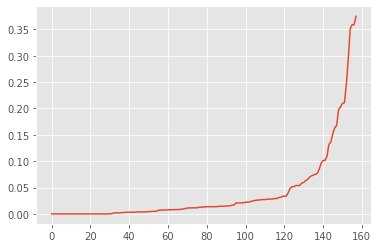

In [24]:
venue_dist = np.sort(venue_dist, axis=0)
venue_dist = venue_dist[:,1]
plt.plot(venue_dist)

In [25]:
venue_model = DBSCAN(eps = 0.1, min_samples = 5)
venue_model.fit(venue_db)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

Creating a column to place the cluster numbers and checking how many unique clusters.

In [26]:
venue = venue.copy()
venue['Clus Num'] = venue_model.labels_


In [27]:
venue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Clus Num
0,St. George,40.644982,-74.079353,M & K spanish restaurant,40.644112,-74.076950,0
1,St. George,40.644982,-74.079353,Green Tea Chinese Restaurant,40.644100,-74.076950,0
2,St. George,40.644982,-74.079353,May May Chinese Restaurant,40.644179,-74.076608,0
3,St. George,40.644982,-74.079353,Papouli's Restaurant,40.642357,-74.076728,0
4,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,0


In [28]:
venue['Clus Num'].unique()

array([ 0, -1,  1,  2,  3,  4,  5,  6,  7,  8,  9])

Creating a venue outlier and cluster dataframe for plotting purposes. 

In [29]:
venue_outlier = venue[venue['Clus Num'] == -1]

print(venue_outlier.shape)
venue_outlier.head()

(78, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Clus Num
6,New Brighton,40.640615,-74.087017,New Pair Jan Chinese Restaurant,40.638615,-74.087341,-1
7,New Brighton,40.640615,-74.087017,Jiang Restaurant,40.638396,-74.087575,-1
28,West Brighton,40.631879,-74.107182,Paoluccis Restaurant,40.630646,-74.103027,-1
29,West Brighton,40.631879,-74.107182,Villa Roma Pizzeria Restaurant,40.634933,-74.110809,-1
30,West Brighton,40.631879,-74.107182,Diamond Forest Chinese Food Restaurant,40.630977,-74.100951,-1


In [30]:
venue_clus = venue[venue['Clus Num'] != -1]

print(venue_clus.shape)
venue_clus.head()

(80, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Clus Num
0,St. George,40.644982,-74.079353,M & K spanish restaurant,40.644112,-74.076950,0
1,St. George,40.644982,-74.079353,Green Tea Chinese Restaurant,40.644100,-74.076950,0
2,St. George,40.644982,-74.079353,May May Chinese Restaurant,40.644179,-74.076608,0
3,St. George,40.644982,-74.079353,Papouli's Restaurant,40.642357,-74.076728,0
4,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,0


In [31]:
# Creates the map of NYC using the latitude and longitude obtained from previous cell
ny_map = folium.Map(location=[latitude,longitude],zoom_start=10)



# Add the markers to the map

# Clusters
for lat,lng,num,venue in zip(venue_clus['Venue Latitude'],venue_clus['Venue Longitude'],venue_clus['Clus Num'],venue_clus['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=4,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
    
    
    
# Outlier  
for lat,lng,num,venue in zip(venue_outlier['Venue Latitude'],venue_outlier['Venue Longitude'],venue_outlier['Clus Num'],venue_outlier['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=4,
    popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
        
    
    




In [32]:
ny_map

In the map above the *outliers* are in **black** and the *clusters* are in **red**

## 3. Summary

Combining crime clusters, venue clusters, neighborhoods and the respective outliers into one map.

In [35]:

ny_map = folium.Map(location=[latitude,longitude],zoom_start=10)



### Crime ###

# Add the markers to the map

# Cluster
for lat,lng,num,crime in zip(crime_clus['Latitude'],crime_clus['Longitude'],crime_clus['Clus Num'],crime_clus['Crime Committed']):
    label = '{}'.format(crime)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
    
    
    
# Outlier  
for lat,lng,num,crime in zip(crime_outlier['Latitude'],crime_outlier['Longitude'],crime_outlier['Clus Num'],crime_outlier['Crime Committed']):
    label = '{}'.format(crime)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
        
    
    

    
  #### Venue #####  
    
# Add the markers to the map

# Venue Clusters
for lat,lng,num,venue in zip(venue_clus['Venue Latitude'],venue_clus['Venue Longitude'], venue_clus['Clus Num'],venue_clus['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='gray',
    fill=True,
    fill_color='gray',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
    
    
    
# Neighborhood Outlier  
for lat,lng,neigh,num in zip(venue_outlier['Neighborhood Latitude'],venue_outlier['Neighborhood Longitude'],venue_outlier['Neighborhood'],venue_outlier['Clus Num']):
    label = '{}'.format(neigh)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7,
    parse_html=False).add_to(ny_map)
        
    
        

In [36]:
ny_map

In the map above the clusters/outliers for both crime and venue dataframe.

1. Crime Clusters : Black
2. Crime Outliers : Red
3. Venue Clusters : Gray
4. Neighborhoods : Blue

In other words the gray color dots are where ther is high density of venues and the black dots are where there is high density of crime. While I wanted to make the crime outliers red to highlight where the low density crime spots are. I also wanted the neighborhoods to stand out and showcase which neighborhoods are near either high density venues, crimes or both so those neighborhoods can be avoided.

We can see that the best neighborhoods that are separate from the high density clusters are more located towards the middle of Staten Island for example __*Heartland Village*__. Also we can see some more good neighborhoods in the upper right between two high density venue clusters for example __*Old Town, Arrochar and Grasmere*__. Lastly we see one more good group of neighborhoods and thats in the bottom left between the high density crime and venue clusters. Example of these neighborhoods is __*Woodrow, Huguenot and Rossville*__. We can also see that high density crimes usually fall at the bottom tip and top tip of Staten Island. The high density venues are located near the top tip and along the right side coast of Staten Island.